In [ ]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dev
Creating: ./data/mnist
Creating: ./data/raw
Saving config to ./data/mnist/dev/config.yaml
Info
Min tensor([-0.7832, -0.7648])
Max tensor([0.5735, 0.6263])
Norm tensor(0.8706)


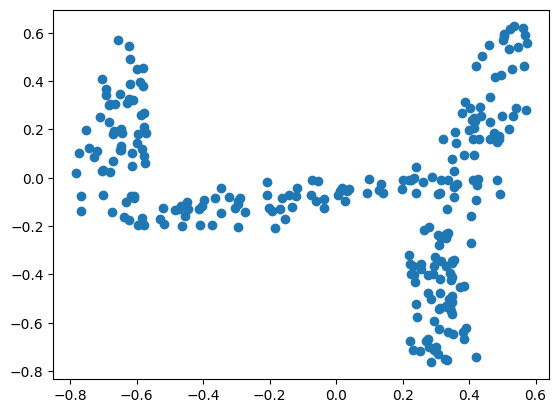

In [ ]:
%autoreload 2

import torch 
import matplotlib.pyplot as plt
from shape_synthesis.plotting.plot2d import plot_point_clouds_grid_2d

from shape_synthesis.datasets.mnist import DataConfig, create_dataset


config = DataConfig(
        root="./data",
        raw="./data/raw",
        num_pts=256,
        module="datasets.mnist",
        batch_size=32,
    )
create_dataset(config, dev=True)

train_pts = torch.load("../data/mnist/dev/train.pt")
train_imgs = torch.load("../data/mnist/dev/train_imgs.pt")

x = train_pts[2]
plt.scatter(x[:,0],x[:,1])


print(72*"=")
print("Info")
print("Min", x.min(dim=0)[0])
print("Max", x.max(dim=0)[0])
print("Norm", torch.norm(x,dim=1).max())
print(72*"=")



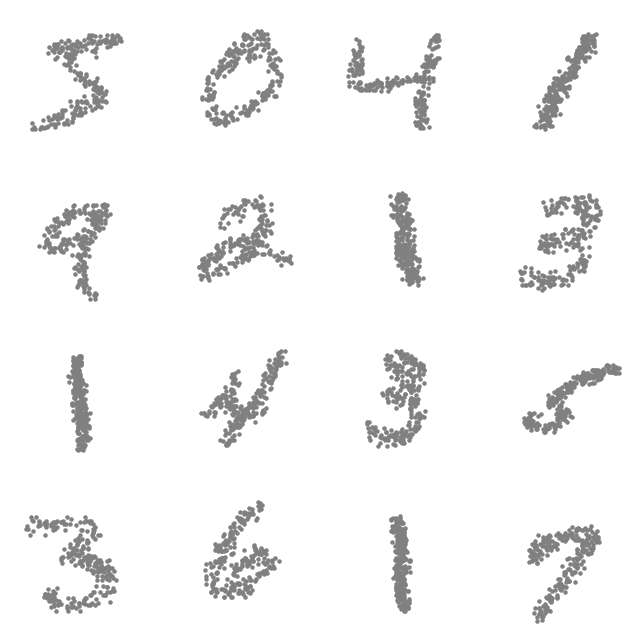

In [76]:
fig = plot_point_clouds_grid_2d(train_pts)


In [71]:
# Plot more samples of the data. 



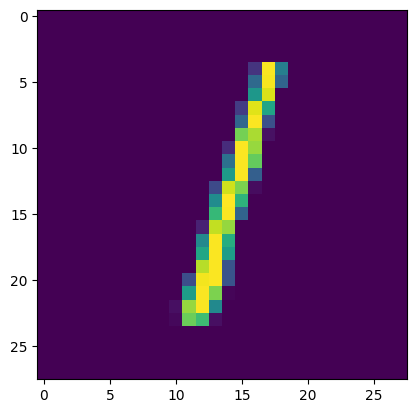

In [72]:
plt.imshow(train_imgs[2])


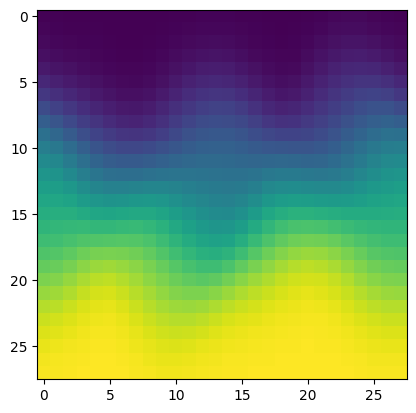

In [73]:
from shape_synthesis.datasets.transforms import get_transform 

transform = get_transform()

ect = transform(train_pts[:10].cuda())
plt.imshow(ect[1].cpu().numpy())


In [74]:
ect.max()

tensor(1., device='cuda:0')